# Plot extreme changes conditioned on AMOC evolution for final 21-year period #

In [16]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import xarray as xr
import pandas as pd
import netCDF4 as nc
import numpy as np
from dask.distributed import Client
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/home/563/sc1326/repos/cdrmip_extremes')
from cdrmip_extremes.configs import data_dir, models, expts
from cdrmip_extremes import load_data, ext_freq, utils
from cdrmip_extremes.plotting import plot_extremes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
client = Client(memory_limit=None,threads_per_worker=1,n_workers=28)

## Load Data ##

#### From previous notebook we have ####

In [18]:
amoc_changes = {
    'CESM2': -4.47,
    'CNRM-ESM2-1': -3.35,
    'MIROC-ES2L': -2.39,
    'NorESM2-LM': -1.22,
    'UKESM1-0-LL': 1.07,
    'GFDL-ESM4': 1.94,
    'CanESM5': 3.11,
    'ACCESS-ESM1-5': 3.28
}
models_amoc_ordered = list(amoc_changes.keys())
models_amoc_ordered

['CESM2',
 'CNRM-ESM2-1',
 'MIROC-ES2L',
 'NorESM2-LM',
 'UKESM1-0-LL',
 'GFDL-ESM4',
 'CanESM5',
 'ACCESS-ESM1-5']

In [19]:
ext_freq_data = load_data.load_ext_freq_data(final=True)

In [20]:
heat_freq = {
    model: ext_freq_data[model]['heat_exceedances'] for model in models_amoc_ordered
}
cold_freq = {
    model: ext_freq_data[model]['cold_exceedances'] for model in models_amoc_ordered
}

In [21]:
cold_freq

{'CESM2': <xarray.Dataset> Size: 780kB
 Dimensions:  (lon: 180, lat: 90, branch: 2)
 Coordinates:
   * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
   * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
     extrema  <U4 16B ...
   * branch   (branch) <U9 72B 'ramp_up' 'ramp_down'
 Data variables:
     sigma1   (branch, lat, lon) float64 259kB ...
     sigma2   (branch, lat, lon) float64 259kB ...
     sigma3   (branch, lat, lon) float64 259kB ...,
 'CNRM-ESM2-1': <xarray.Dataset> Size: 780kB
 Dimensions:  (lon: 180, lat: 90, branch: 2)
 Coordinates:
   * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
   * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
     extrema  <U4 16B ...
   * branch   (branch) <U9 72B 'ramp_up' 'ramp_down'
 Data variables:
     sigma1   (branch, lat, lon) float64 259kB ...
     sigma2   (branch, lat, lon) float64 259kB ...
     sigma3   (branch, lat, 

#### Load extreme month temperature data ####

In [22]:
ext_month_tas = load_data.load_ext_month_tas(final=True)

In [23]:
ext_month_tas = {
    model: ext_month_tas[model] for model in models_amoc_ordered
}
ext_month_tas

{'CESM2': <xarray.Dataset> Size: 11MB
 Dimensions:  (branch: 2, extrema: 2, year: 42, lat: 90, lon: 180)
 Coordinates:
   * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
   * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * extrema  (extrema) <U4 32B 'heat' 'cold'
   * year     (year) int64 336B 35 36 37 38 39 40 41 ... 334 335 336 337 338 339
   * branch   (branch) <U9 72B 'ramp_up' 'ramp_down'
 Data variables:
     tas      (branch, extrema, year, lat, lon) float32 11MB ...
 Attributes: (12/44)
     CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
     source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
     institution:            National Center for Atmospheric Research, Climate...
     Conventions:            CF-1.7 CMIP-6.2
     activity_id:            CMIP
     branch_method:          standard
     ...                     ...
     tracking_id:            hdl:21.14100

### Determine differences ###

In [24]:
heat_freq_differences, heat_freq_agreement = ext_freq.calc_gwl_differences(heat_freq)
cold_freq_differences, cold_freq_agreement = ext_freq.calc_gwl_differences(cold_freq)

In [25]:
ext_month_tas_differences = {
    model: utils.compare_gwl_means(ds)['difference'] 
    for model, ds in ext_month_tas.items()
}

## Plot ##

In [28]:
def plot_freq_diff_amoc_stereo(ext_type, frequencies, threshold, levels):
    # define symbols for thresholds for title
    heat_symbs = {'sigma1': '1$\sigma$',
                  'sigma2': '2$\sigma$',
                  'sigma3': '3$\sigma$'}
    cold_symbs = {'sigma1': '-0.25$\sigma$',
                  'sigma2': '-0.5$\sigma$',
                  'sigma3': '-1$\sigma$'}
    
    if ext_type == 'Heat':
        symb = heat_symbs[threshold]
        cmap = 'RdBu_r'
    elif ext_type == 'Cold':
        symb = cold_symbs[threshold]
        cmap = 'RdBu' 
    
    to_plot = {}
    for model, data in frequencies.items():
        ramp_up = data.sel(branch='ramp_up')[threshold]
        ramp_down = data.sel(branch='ramp_down')[threshold]
        to_plot[model] = ramp_down - ramp_up

    fig, axes = plt.subplots(2, 4, 
                             subplot_kw={"projection": ccrs.NorthPolarStereo()}, 
                             figsize=(16, 7),
                             sharey=True)

    cbar_kwargs = {
        "fraction": 0.02, "aspect": 20,
        "label": "% Years", 'orientation': 'vertical',
        'location': 'right', 'pad': 0.01,
        'anchor': (0.5, -4), 'extend': 'both'
    }

    norm = BoundaryNorm(levels, ncolors=plt.cm.get_cmap(cmap).N, clip=True)

    for model, ax in zip(frequencies.keys(), axes.flat):
        da = to_plot[model]  
        lon, lat = da.lon, da.lat
        mesh = ax.pcolormesh(lon, lat, da, 
                             transform=ccrs.PlateCarree(),
                             cmap=cmap,
                             norm=norm,
                             shading='auto')
        ax.set_title(f"{model}, $\Delta$ = {amoc_changes[model]:.2f} Sv", fontsize=16)
        ax.set_extent([-100, 60, 30, 90], crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.gridlines(draw_labels=False)

    cbar_ax = fig.add_axes([1.01, 0.06, 0.01, 0.8])
    cbar = fig.colorbar(mesh, cax=cbar_ax, **cbar_kwargs)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label("Difference in % of years", fontsize=16)
    fig.text(0,1.0,
         '(a)',
         fontsize=20,
         va='bottom',
         ha='left'
        )

    fig.suptitle(f"Change in {symb} {ext_type} Extreme Exceedance Frequency by End of Simulation",
                 fontsize=25, y=1.0)
    fig.tight_layout()
    plt.show()

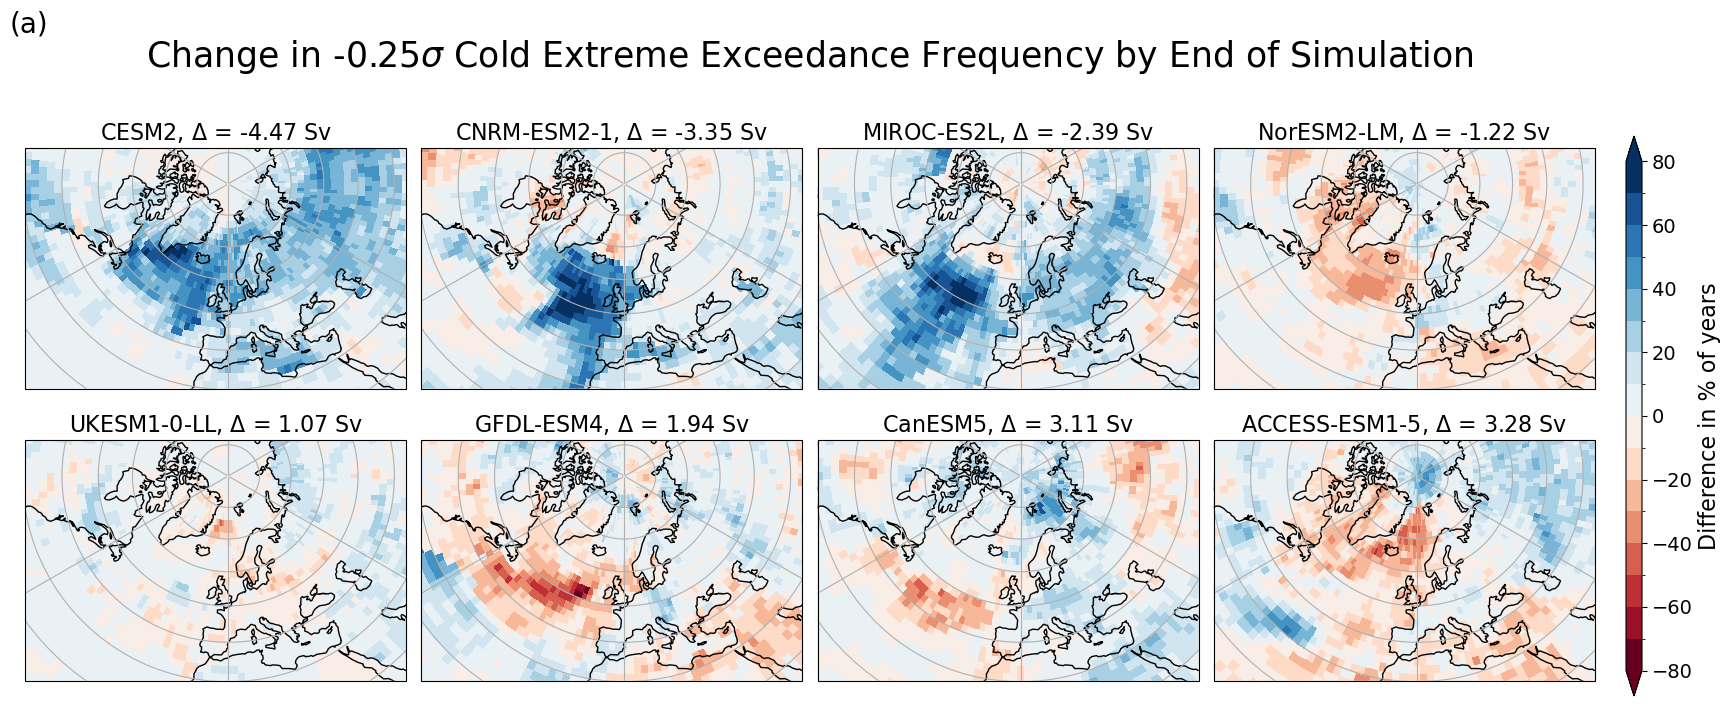

In [29]:
plot_freq_diff_amoc_stereo(
    'Cold',
    cold_freq,
    'sigma1',
    levels = np.linspace(-80,80,17)
                    )

In [30]:
def plot_intens_diff_amoc_stereo(ext_type,to_plot,levels,AMOC_changes):

    cmap = 'RdBu_r'
    norm = BoundaryNorm(levels, ncolors=plt.cm.get_cmap(cmap).N, clip=True)
    
    fig, axes = plt.subplots(2, 4, 
                             subplot_kw={"projection": ccrs.NorthPolarStereo()}, 
                             figsize=(16, 7),
                             sharey=True)

    cbar_kwargs = {
        "fraction": 0.02, "aspect": 20,
        "label": "% Years", 'orientation': 'vertical',
        'location': 'right', 'pad': 0.01,
        'anchor': (0.5, -4), 'extend': 'both'
    }
    
    for (model,da), ax in zip(to_plot.items(), axes.flat):
        da = da.sel(extrema=ext_type).tas
        lon, lat = da.lon, da.lat
        mesh = ax.pcolormesh(lon, lat, da, 
                             transform=ccrs.PlateCarree(),
                             cmap=cmap,
                             norm=norm,
                             shading='auto')
        ax.set_title(f"{model}, $\Delta$ = {AMOC_changes[model]:.2f} Sv", fontsize=16)
        ax.set_extent([-100, 60, 30, 90], crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.gridlines(draw_labels=False)

    cbar_ax = fig.add_axes([1.01, 0.06, 0.01, 0.8])
    cbar = fig.colorbar(mesh, cax=cbar_ax, **cbar_kwargs)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label("SAT Anomaly ($^o$C)", fontsize=16)

    fig.text(0,1.0,
         '(b)',
         fontsize=20,
         va='bottom',
         ha='left'
        )
    
    fig.suptitle(f"Change in {ext_type.capitalize()}est Month Temperature by End of Simulation",
                 fontsize=25,
                 y=1.0
                )
    fig.tight_layout()
    plt.show()
    plt.close(fig)

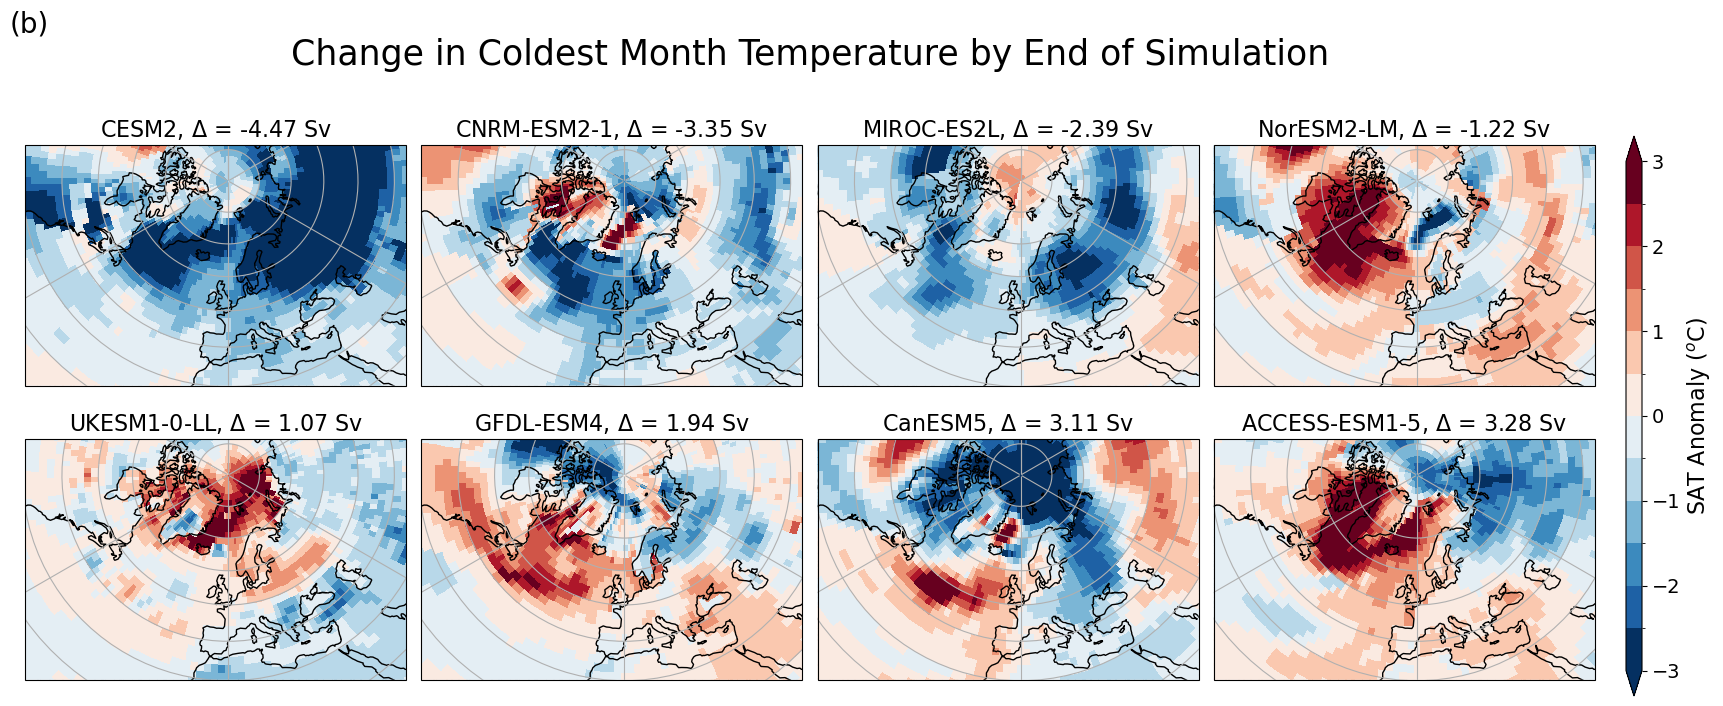

In [31]:
plot_intens_diff_amoc_stereo(
    'cold',
    ext_month_tas_differences,
    np.linspace(-3,3,13),
    amoc_changes
)

## Plot mean changes grouped by AMOC sensitivity ##

In [32]:
AMOC_models = ["CESM2","MIROC-ES2L","NorESM2-LM",'CNRM-ESM2-1',]
non_AMOC_models = ['ACCESS-ESM1-5','CanESM5','GFDL-ESM4',"UKESM1-0-LL"]

In [33]:
AMOC_heat_freq_mean = xr.concat([heat_freq_differences[model] for model in AMOC_models],
                                  dim='model',
                                 compat='override',
                                 coords='minimal').mean(dim='model')
non_AMOC_heat_freq_mean = xr.concat([heat_freq_differences[model] for model in non_AMOC_models],
                                      dim='model',
                                      compat='override',
                                      coords='minimal').mean(dim='model')

In [34]:
AMOC_cold_freq_mean = xr.concat([cold_freq_differences[model] for model in AMOC_models],
                                  dim='model',
                                 compat='override',
                                 coords='minimal').mean(dim='model')
non_AMOC_cold_freq_mean = xr.concat([cold_freq_differences[model] for model in non_AMOC_models],
                                      dim='model',
                                      compat='override',
                                      coords='minimal').mean(dim='model')

In [37]:
cbar_kwargs = {
        "fraction": 0.02, "aspect": 20,
        "label": "% Years", 'orientation': 'vertical',
        'location': 'right', 'pad': 0.01,
        'anchor': (0.5, -4), 'extend': 'both'
    }

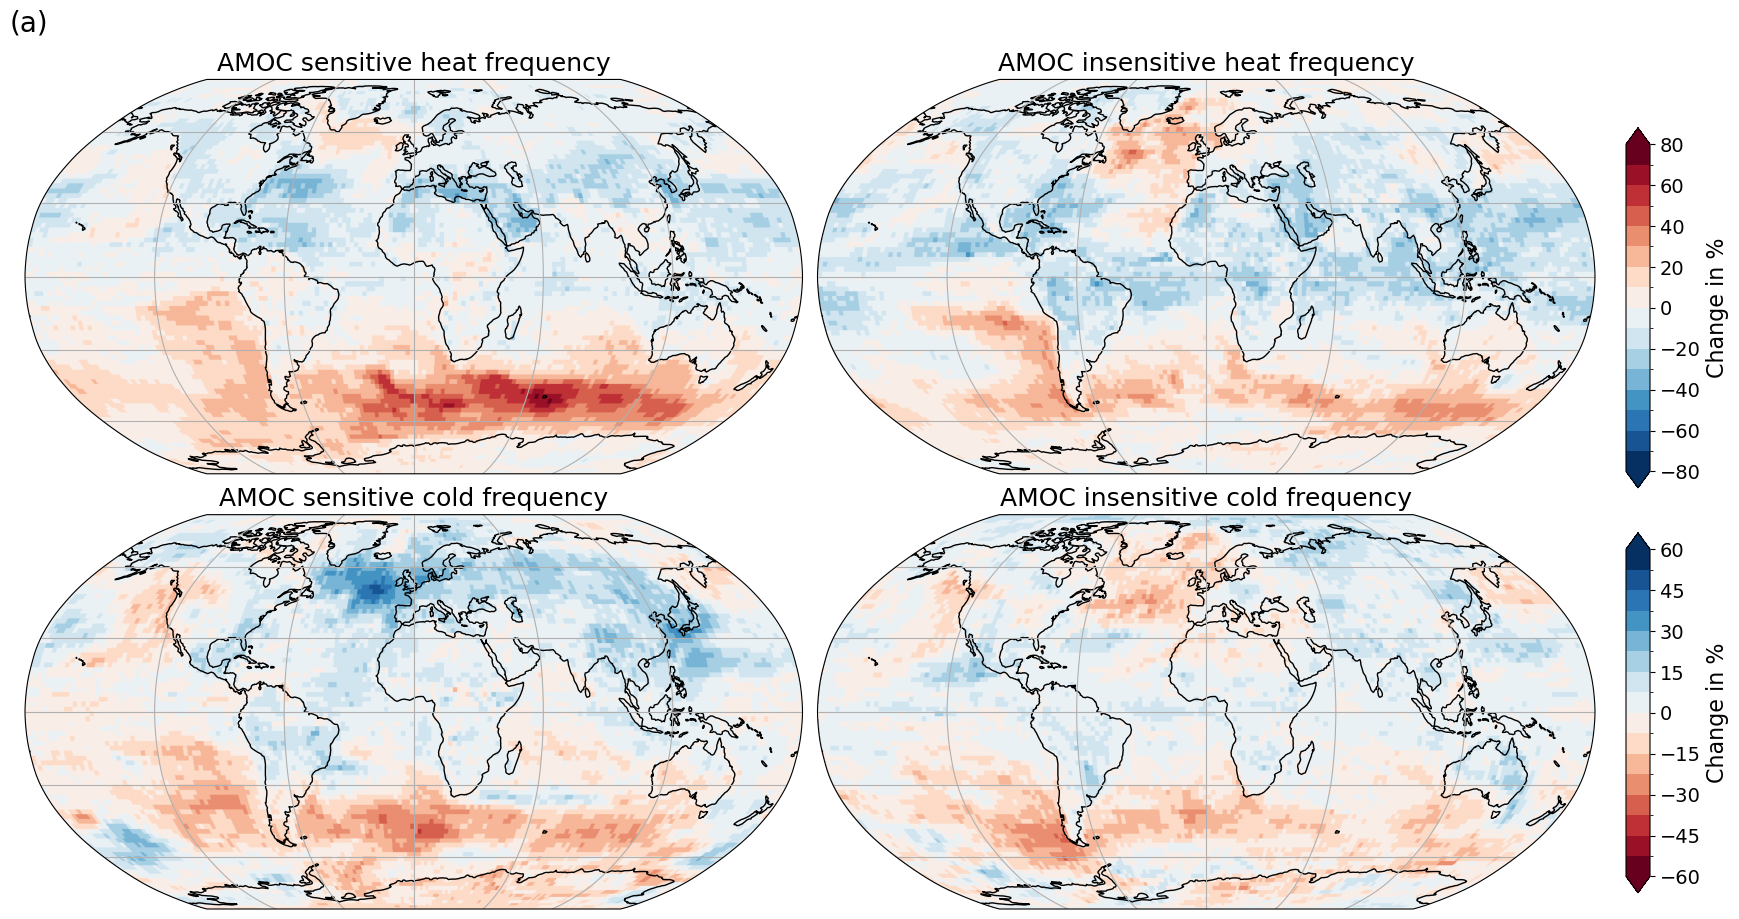

In [38]:
to_plot_heat = {
    'AMOC sensitive heat frequency':AMOC_heat_freq_mean.sigma2,
    'AMOC insensitive heat frequency':non_AMOC_heat_freq_mean.sigma2,
}
to_plot_cold = {
    'AMOC sensitive cold frequency':AMOC_cold_freq_mean.sigma1,
    'AMOC insensitive cold frequency':non_AMOC_cold_freq_mean.sigma1,
}

levels_heat = np.linspace(-80,80,17)
norm_heat = BoundaryNorm(levels_heat, ncolors=plt.cm.RdBu_r.N, clip=True)

levels_cold = np.linspace(-60,60,17)
norm_cold = BoundaryNorm(levels_cold, ncolors=plt.cm.RdBu.N, clip=True)

fig, axes = plt.subplots(2,2,subplot_kw={'projection': ccrs.Robinson()}, figsize=(16, 9))


for (model,da), ax in zip(to_plot_heat.items(),axes.flat[:2]):

    im = ax.imshow(
        da,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        norm=norm_heat,
        origin='lower',
        extent = (0,360,-90,90)
    )        
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.set_title(model,fontsize=18)

cbar_ax1 = fig.add_axes([1.01,0.5,0.015,0.4])
cbar1 = fig.colorbar(im,
                    cax=cbar_ax1,
                    **cbar_kwargs
                   )
cbar1.ax.tick_params(labelsize=14) 
cbar1.set_label("Change in %", fontsize=16)

for (model,da), ax in zip(to_plot_cold.items(),axes.flat[2:]):

    im = ax.imshow(
        da,
        transform=ccrs.PlateCarree(),
        cmap='RdBu',
        norm=norm_cold,
        origin='lower',
        extent = (0,360,-90,90)
    )        
    # Add coastlines and grid
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.set_title(model,fontsize=18)

cbar_ax2 = fig.add_axes([1.01,0.05,0.015,0.4])
cbar2 = fig.colorbar(im,
                    cax=cbar_ax2,
                    **cbar_kwargs
                   )
cbar2.ax.tick_params(labelsize=14)  # Adjust tick label size
cbar2.set_label("Change in %", fontsize=16)

fig.text(0,1.0,
         '(a)',
         fontsize=20,
         va='bottom',
         ha='left'
        )

fig.tight_layout()

In [39]:
AMOC_ext_month_tas_mean = xr.concat([ext_month_tas_differences[model].tas for model in AMOC_models],
                                  dim='model',
                                 compat='override',
                                 coords='minimal').mean(dim='model')
non_AMOC_ext_month_tas_mean = xr.concat([ext_month_tas_differences[model].tas for model in non_AMOC_models],
                                      dim='model',
                                      compat='override',
                                      coords='minimal').mean(dim='model')

In [40]:
to_plot_heat = {
    'AMOC sensitive hottest month':AMOC_ext_month_tas_mean.sel(extrema='heat'),
    'AMOC insensitive hottest month':non_AMOC_ext_month_tas_mean.sel(extrema='heat'),
}
to_plot_cold = {
    'AMOC sensitive coldest month':AMOC_ext_month_tas_mean.sel(extrema='cold',
    'AMOC insensitive coldest month':non_AMOC_ext_month_tas_mean.sel(extrema='cold'),
}

levels_heat = np.linspace(-2,2,17)
norm_heat = BoundaryNorm(levels_heat, ncolors=plt.cm.RdBu_r.N, clip=True)

levels_cold = np.linspace(-2,2,17)
norm_cold = BoundaryNorm(levels_cold, ncolors=plt.cm.RdBu.N, clip=True)

fig, axes = plt.subplots(2,2,subplot_kw={'projection': ccrs.Robinson()}, figsize=(16, 9))


for (model,da), ax in zip(to_plot_heat.items(),axes.flat[:2]):

    im = ax.imshow(
        da,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        norm=norm_heat,
        origin='lower',
        extent = (0,360,-90,90)
    )        
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.set_title(model,fontsize=18)

cbar_ax1 = fig.add_axes([1.01,0.5,0.015,0.4])
cbar1 = fig.colorbar(im,
                    cax=cbar_ax1,
                    **cbar_kwargs
                   )
cbar1.ax.tick_params(labelsize=14) 
cbar1.set_label("Change in %", fontsize=16)

for (model,da), ax in zip(to_plot_cold.items(),axes.flat[2:]):

    im = ax.imshow(
        da,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        norm=norm_cold,
        origin='lower',
        extent = (0,360,-90,90)
    )        
    # Add coastlines and grid
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.set_title(model,fontsize=18)

cbar_ax2 = fig.add_axes([1.01,0.05,0.015,0.4])
cbar2 = fig.colorbar(im,
                    cax=cbar_ax2,
                    **cbar_kwargs
                   )
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label("SAT Difference", fontsize=16)

fig.text(0,1.0,
         '(b)',
         fontsize=20,
         va='bottom',
         ha='left'
        )

fig.tight_layout()

SyntaxError: closing parenthesis '}' does not match opening parenthesis '(' on line 6 (755587438.py, line 8)